In [40]:
import keras
keras.__version__

'2.3.1'

## 观察耶拿天气数据集的数据

In [41]:
import os
data_dir = 'resources/jena_climate/jena_climate_2009_2016.csv'
fname = os.path.join(data_dir)

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


### 绘制温度时间序列

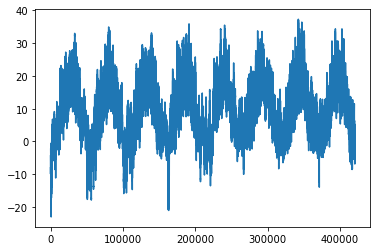

In [42]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

from matplotlib import pyplot as plt

temp = float_data[:, 1]  # 温度（单位：摄氏度）
plt.plot(range(len(temp)), temp)
plt.show()

### 绘制前10天的温度时间序列

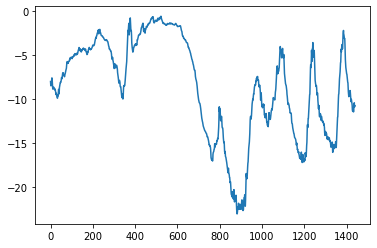

In [43]:
plt.plot(range(1440), temp[:1440])
plt.show()

### 对前200000个时间步数据标准化

In [44]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

### 生成时间序列样本及其目标的生成器
* data：浮点数数据组成的原始数组（已标准化）
* lookback：输入数据应该包括过去多少个时间步
* delay：目标应该在未来多少个时间步之后
* min_index 和 max_index：data数组中的索引，用于界定需要抽取哪些时间步。
这有助于保存一部分数据用于验证、另一部分用于测试。
* shuffle：是打乱样本，还是按顺序抽取样本
* batch_size：每个批量的样本数
* step：数据采样的周期（单位：时间步），我们设其为6，为的是每小时抽取一个数据点

In [45]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

### 准备训练生成器、验证生成器和测试生成器

In [46]:
lookback = 1440 # 过去10天
step = 6 # 观测数据的采样频率是每个小时一个数据点
delay = 144 # 目标是未来24小时后的数据
batch_size = 128 # 每个批次样本数

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

#为了查看整个验证集，需要从val_gen抽取多少次
val_steps = (300000 - 200001 - lookback) // batch_size
# 为了查看整个测试机，需要从test_gen抽取多少次
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### 计算符合常识的基准方法的MAE（平均绝对误差）

In [47]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()
# 将MAE转换为摄氏温度误差
celsius_mae = 0.29 * std[1]

0.2897359729905486


### 训练并评估一个密集连接模型

Epoch 1/20
500/500 [==============================] - 7s 15ms/step - loss: 1.2898 - val_loss: 0.5477

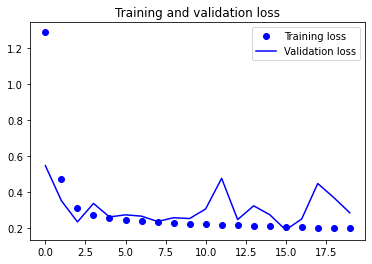

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

# 绘制结果
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 训练并评估一个基于GRU的模型

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

# 绘制结果
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Epoch 1/20
500/500 [==============================] - 71s 141ms/step - loss: 0.3122 - val_loss: 0.3261